# Testing with Concept Activation Vectors (TCAV)

Introduced by [Kim et al. (2018)](https://arxiv.org/pdf/1711.11279.pdf)

In [1]:
from torchvision.models import resnet50

model = resnet50(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [2]:
#concept = "cup"
concept = "chair"
#k_class = "bottle"
k_class = "dining table"

## Get images for classifier

We will use the [pycocotools](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb) API to retrieve some examples of chairs:

In [3]:
from pycocotools.coco import COCO

coco = COCO("./datasets/instances_val2017.json")

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


Let's get the IDs of the images in the coco dataset that have the concept of _chair_:

In [4]:
concept_cat_id = coco.getCatIds(catNms=[concept])
concept_imgs_ids = coco.getImgIds(catIds=concept_cat_id)
len(concept_imgs_ids)

580

Let's remove the images where chairs are accompanied by dining table:

In [5]:
overlap_cats_ids = coco.getCatIds(catNms=[concept, k_class])
overlap_imgs_ids = coco.getImgIds(catIds=overlap_cats_ids)
len(overlap_imgs_ids)

241

In [6]:
concept_imgs_ids = [img_id for img_id in concept_imgs_ids if img_id not in overlap_imgs_ids]
len(concept_imgs_ids)

339

Let's grab random images for the other class of the classifier:

In [7]:
import random

all_imgs_ids = list(coco.imgs.keys())
not_concept_imgs_ids = [img_id for img_id in all_imgs_ids if img_id not in concept_imgs_ids]
random.Random(0).shuffle(not_concept_imgs_ids)
not_concept_imgs_ids = not_concept_imgs_ids[:len(concept_imgs_ids)]

assert not any(img_id in not_concept_imgs_ids for img_id in concept_imgs_ids)

## Extract activations from images

In [8]:
from torchvision import transforms

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

preprocessing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

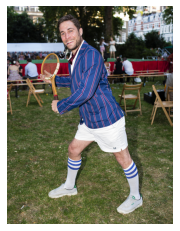

In [9]:
from PIL import Image
import skimage.io as io
import matplotlib.pyplot as plt

img_id = concept_imgs_ids[18]
img_url =  coco.loadImgs(img_id)[0]["coco_url"]
img = io.imread(img_url)
img_pil = Image.fromarray(img)
prepro_img = preprocessing(img_pil)
#type(img)

plt.axis('off')
plt.imshow(img)
plt.show()

In [10]:
import numpy as np
from PIL import Image
import skimage.io as io

class_ids = np.concatenate(
    (np.zeros(len(concept_imgs_ids)), np.ones(len(not_concept_imgs_ids))),
    axis=0
)

all_imgs_ids = np.concatenate((concept_imgs_ids, not_concept_imgs_ids))
imgs = []
for img_id in all_imgs_ids:
    img_url =  coco.loadImgs(int(img_id))[0]["coco_url"]
    img = io.imread(img_url)
    img_pil = Image.fromarray(img).convert("RGB")
    img_prepro = preprocessing(img_pil)
    img_unsq = img_prepro.unsqueeze(0)
    imgs.append(img_unsq)

In [11]:
import torch

imgs_tensor = torch.cat(imgs)
imgs_tensor.shape

torch.Size([678, 3, 224, 224])

In [12]:
model = resnet50(pretrained=True)
model.eval()

features = []

def get_representation(mod, inp, out):
    out = out.detach()
    features.append(out)

handle = model.layer4.register_forward_hook(get_representation)

Forward pass:

In [13]:
out = model(imgs_tensor)

Let's load the tensors:

In [42]:
features_test = []

for i in range(6):
    batch_data = torch.load(f"./datasets/layer4_features_{i+1}.pt")
    features_test.append(batch_data)

features_test = torch.cat(features_test)

In [43]:
features_test.shape

torch.Size([678, 2048, 7, 7])

In [47]:
features_resized = torch.reshape(features_test, (features_test.shape[0],-1,))
features_resized.shape

torch.Size([678, 100352])

In [31]:
# size_batch = 113
# n_batches = 6

# i = 0
# for batch in range(n_batches):
#     torch.save(features[0][i:(i+size_batch)].clone(), f"layer4_features_{batch+1}.pt")
#     i += size_batch